# Differential Analysis 

Expression Proteomics includes the analysis of protein expression at larger scale. It helps identify main proteins in a particular sample, and those proteins differentially expressed in related samples, such as diseased vs. healthy tissue.

The tool DEqMS is used here. DEqMS builds on top of Limma, a widely-used R package for microarray data analysis (Smyth G. et al 2004), and improves it with proteomics data specific properties, accounting for variance dependence on the number of quantified peptides or PSMs for statistical testing of differential protein expression.

Limma assumes a common prior variance for all proteinss, the function spectraCounteBayes in DEqMS package estimate prior variance for proteins quantified by different number of PSMs.

In [1]:
objects <- load("/mnt/data/Proteomics/output/protein_objects.RData")
objects

[1] "metadata"           "protein.table.norm" "pep.count.table"

In [2]:
library(DEqMS)

Loading required package: ggplot2

Loading required package: limma



In [3]:
head(metadata)

,sampleID,diagnosis,age,sex,pmi,APOEgeno
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,Intensity.ctl033,CONTROL,81,1,20,E3/E3
2,Intensity.ad059,AD,83,0,18,E3/E3
3,Intensity.ctl035,CONTROL,80,1,22,E3/E3
4,Intensity.ctl037,CONTROL,90,0,14,E3/E3
5,Intensity.ad061,AD,81,1,7,E3/E3
6,Intensity.ad063,AD,90,1,14,E3/E3


In [4]:
head(protein.table.norm)

,Intensity.ctl033,Intensity.ad059,Intensity.ctl035,Intensity.ctl037,Intensity.ad061,Intensity.ad063,Intensity.ctl039,Intensity.ctl041,Intensity.ad065,Intensity.ad067,...,Intensity.ad087,Intensity.ad089,Intensity.ctl051,Intensity.ctl053,Intensity.ad091,Intensity.ad093,Intensity.ad095,Intensity.ctl055,Intensity.ad097,Intensity.ctl057
MBP|P02686-5,36.63710,36.63710,36.63710,36.63710,36.63710,36.63710,36.54592,36.63710,36.54589,36.63710,...,36.12127,35.86841,36.59142,36.63710,36.63710,36.63710,36.54583,36.63710,36.63710,36.51194
MBP|P02686,36.54586,36.54588,36.54593,36.54582,36.54583,36.54584,36.51220,36.54492,36.51211,36.54592,...,35.90475,35.79846,36.59142,36.54578,36.54587,36.54590,36.51197,36.54587,36.54586,36.46777
MBP|P02686-3,36.51203,36.51208,36.51223,36.51194,36.51197,36.51200,36.46792,36.50957,36.46787,36.51220,...,35.86745,35.76364,36.51208,36.51182,36.51205,36.51214,36.46778,36.51205,36.51203,36.44552
MBP|H7BYR8,36.46782,36.46785,36.45924,36.46777,36.46778,36.46780,36.44932,36.46637,36.44806,36.46792,...,35.78061,35.71571,36.45914,36.46770,36.28446,36.46789,35.90489,36.46783,36.46782,36.01108
MBP|P02686-6,36.44679,36.44764,36.45924,36.44552,36.44595,36.44637,36.12485,36.41076,36.12378,36.44932,...,35.78061,35.65764,36.45914,36.44383,36.28446,36.44848,35.86777,36.44721,36.44679,36.01108
GFAP|P14136,35.86809,36.12342,35.58144,36.12163,36.12199,36.12235,35.26296,35.38961,36.63710,35.76420,...,36.63710,35.61546,36.12342,35.45154,36.46783,36.12414,36.63710,35.14727,35.79828,35.51202


In [5]:
head(pep.count.table)

,count
,<dbl>
MBP|P02686-5,1
MBP|P02686,21
MBP|P02686-3,1
MBP|H7BYR8,2
MBP|P02686-6,1
GFAP|P14136,46


* prepare model sets with covariates

In [6]:
model.matrix=model.matrix(~0+diagnosis+age+sex+pmi,data = metadata)
colnames(model.matrix)=c("case","control","age","sexMale","pmi")
head(model.matrix)

,case,control,age,sexMale,pmi
1,0,1,81,1,20
2,1,0,83,0,18
3,0,1,80,1,22
4,0,1,90,0,14
5,1,0,81,1,7
6,1,0,90,1,14


In [7]:
contrast.matrix.cov <- makeContrasts(case - control, levels = model.matrix)
set.seed(1)

* fit the linear model

In [8]:
# This code fits the linear model, smooths the standard errors and estimate prior variance for proteins.
fit.cov <- lmFit(protein.table.norm, model.matrix)
fit.cov <- contrasts.fit(fit.cov, contrast.matrix.cov)
fit.cov <- eBayes(fit.cov)

fit.cov$count = pep.count.table[rownames(fit.cov$coefficients),"count"]
fit.cov2 = spectraCounteBayes(fit.cov)

* get DEqMS results

DEqMS results contains limma output plus DEqMS t-statistics (sca.t), p-values (sca.P.Value) and BH method adjusted DEqMS p-values (sca.adj.pval)

In [9]:
DEqMS.results = outputResult(fit.cov2,coef_col = 1)
DEqMS.results$gene <- sapply(strsplit(as.character(DEqMS.results$gene),'|',fixed=TRUE), "[", 1)

head(DEqMS.results)

write.table(DEqMS.results,"/mnt/data/Proteomics/output/DE_case_ctrl.csv")

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,count,sca.t,sca.P.Value,sca.adj.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
APP|P05067-7,2.3587749,29.92783,11.103883,3.290510e-12,1.017755e-08,17.058680,APP,11,11.318655,1.410317e-12,4.362112e-09
PDE1A|P54750-8,-1.0406707,26.64318,-7.204322,4.797436e-08,4.946156e-05,8.441506,PDE1A,6,-7.279349,3.306335e-08,3.555598e-05
DIP2B|Q9P265,1.2507248,25.70625,7.268396,4.035298e-08,4.946156e-05,8.601355,DIP2B,4,7.263992,3.448688e-08,3.555598e-05
ESYT1|Q9BSJ8,0.6423867,28.07385,6.191968,7.798977e-07,4.824447e-04,5.851358,ESYT1,12,6.432285,3.504469e-07,2.709830e-04
RPS11|P62280,0.8052748,28.25380,6.095794,1.021138e-06,5.263968e-04,5.599909,RPS11,7,6.190062,6.963670e-07,4.307726e-04
RPL36AL|Q969Q0,1.1457004,26.36613,6.256801,6.505754e-07,4.824447e-04,6.020425,RPL36AL,2,6.097194,9.070842e-07,4.676019e-04


### Visualisation

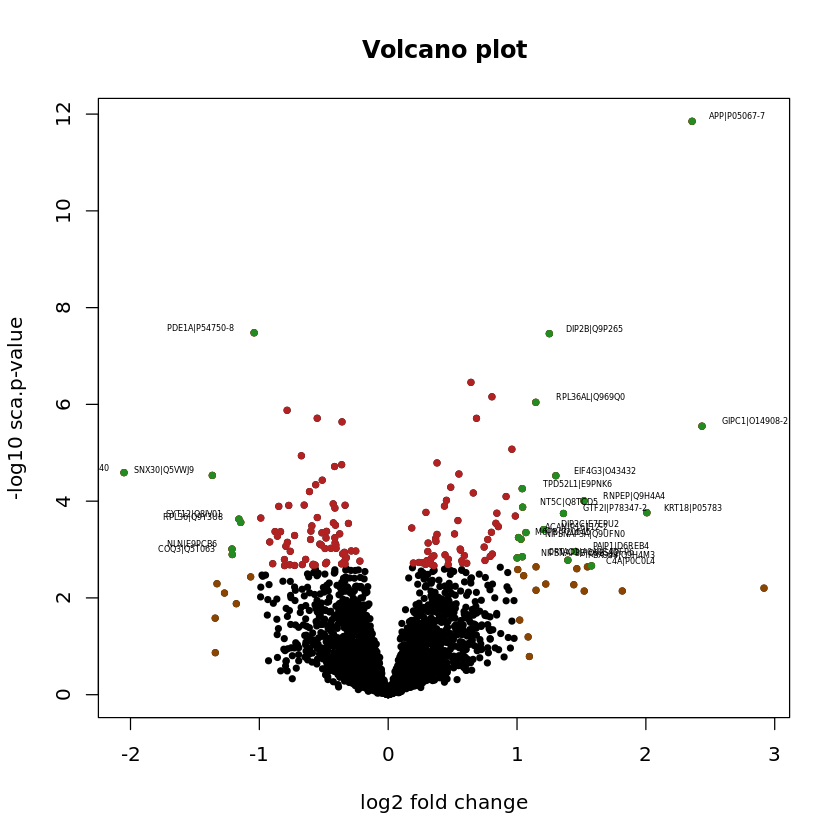

In [10]:
# volcano plot
with(DEqMS.results, plot(logFC, -log10(sca.P.Value), pch=20, main="Volcano plot", ylab="-log10 sca.p-value", xlab="log2 fold change"))

# Add colored points: red if padj<0.05, orange of log2FC>1, green if both)
with(subset(DEqMS.results, sca.adj.pval<.05 ), points(logFC, -log10(sca.P.Value), pch=20, col="firebrick"))
with(subset(DEqMS.results, abs(logFC)>1), points(logFC, -log10(sca.P.Value), pch=20, col="darkorange4"))
set<-subset(DEqMS.results, sca.adj.pval<.05 & abs(logFC)>1)
with(set, points(logFC, -log10(sca.P.Value), pch=20, col="forestgreen"))

# Label points with the textxy function from the calibrate plot
suppressPackageStartupMessages(library(calibrate))
with(set, textxy(logFC, -log10(sca.P.Value), labs=rownames(set), cex=.4))
# if I use as labels rownames(alltable.annot) it is ilegible

A volcano plot is a type of scatterplot that shows statistical significance (P value) versus magnitude of change (fold change). It enables quick visual identification of genes with large fold changes that are also statistically significant. These may be the most biologically significant genes. In a volcano plot, the most upregulated genes are towards the right, the most downregulated genes are towards the left, and the most statistically significant genes are towards the top.

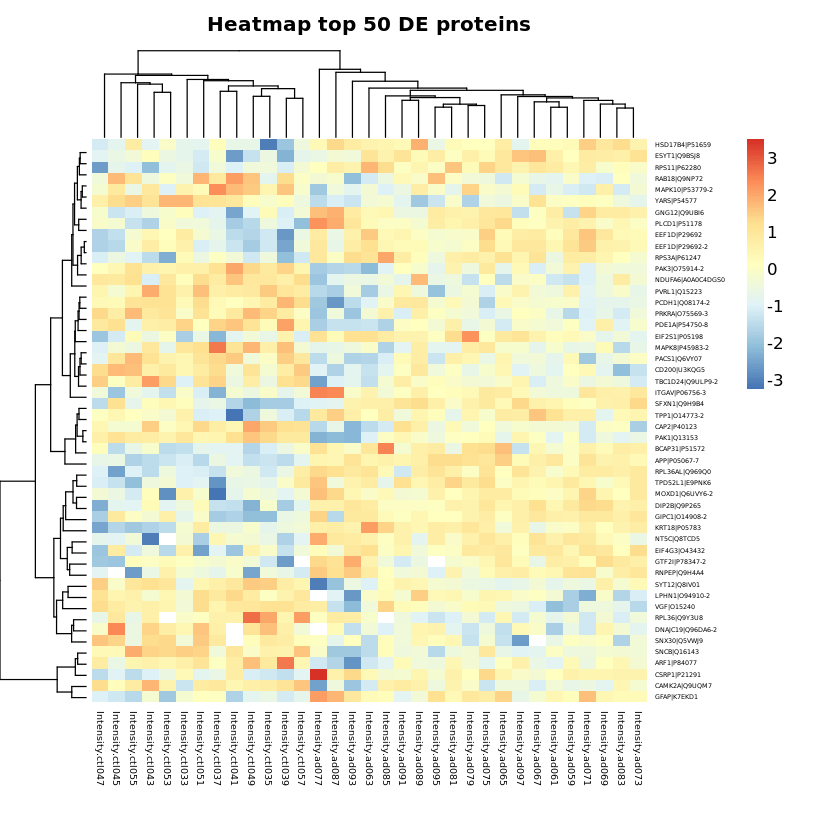

In [12]:
heatmapset<-protein.table.norm[rownames(DEqMS.results[1:50 ,]) ,] #top 50 DE proteins

suppressPackageStartupMessages(library(NMF))
aheatmap(as.matrix(heatmapset),Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",main="Heatmap top 50 DE proteins")

In heatmaps the data is displayed in a grid where each row represents a gene and each column represents a sample. The colour and intensity of the boxes is used to represent changes (not absolute values) of protein intensity.